In [1]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import shutil
import os
import time
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib import cm
import functools

print = functools.partial(print, flush=True)

interest_num = [3,6]
ori_img_size = 28
img_size = 4
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1
inference_batch_size = 1



# Weiwen: modify the target classes starting from 0. Say, [3,6] -> [0,1]
def modify_target(target):
    for j in range(len(target)):
        for idx in range(len(interest_num)):
            if target[j] == interest_num[idx]:
                target[j] = idx
                break
    new_target = torch.zeros(target.shape[0],2)
    for i in range(target.shape[0]):        
        if target[i].item() == 0:            
            new_target[i] = torch.tensor([1,0]).clone()     
        else:
            new_target[i] = torch.tensor([0,1]).clone()
               
    return target,new_target

# Weiwen: select sub-set from MNIST
def select_num(dataset,interest_num):
    labels = dataset.targets #get labels
    labels = labels.numpy()
    idx = {}
    for num in interest_num:
        idx[num] = np.where(labels == num)
    fin_idx = idx[interest_num[0]]
    for i in range(1,len(interest_num)):           
        fin_idx = (np.concatenate((fin_idx[0],idx[interest_num[i]][0])),)
    
    fin_idx = fin_idx[0]    
    dataset.targets = labels[fin_idx]
    dataset.data = dataset.data[fin_idx]
    dataset.targets,_ = modify_target(dataset.targets)
    return dataset

################ Weiwen on 12-30-2020 ################
# Function: ToQuantumData from Listing 1
# Note: Coverting classical data to quantum data
######################################################
class ToQuantumData(object):
    def __call__(self, tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data = tensor.to(device)
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len, vec_len)
        input_matrix[0] = input_vec
        input_matrix = np.float64(input_matrix.transpose(0,1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = torch.tensor(np.dot(u, v))
        output_data = output_matrix[:, 0].view(1, img_size,img_size)
        return output_data

################ Weiwen on 12-30-2020 ################
# Function: ToQuantumData from Listing 1
# Note: Coverting classical data to quantum matrix
######################################################
class ToQuantumMatrix(object):
    def __call__(self, tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data = tensor.to(device)
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len, vec_len)
        input_matrix[0] = input_vec
        input_matrix = np.float64(input_matrix.transpose(0,1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = torch.tensor(np.dot(u, v))
        return output_matrix                      

In [2]:
################ Weiwen on 12-30-2020 ################
# Using torch to load MNIST data
######################################################

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.Resize((ori_img_size,ori_img_size)),
                                transforms.ToTensor()])
# Path to MNIST Dataset
train_data = datasets.MNIST(root='./data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)

train_data = select_num(train_data,interest_num)
test_data =  select_num(test_data,interest_num)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
    num_workers=num_workers, shuffle=True, drop_last=True)


Batch Id: 0, Target: tensor([1])


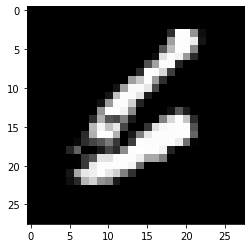

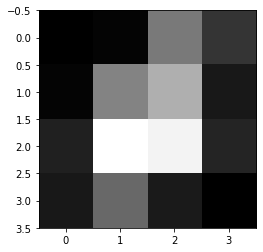

Classical Data: tensor([0.0000, 0.0078, 0.2157, 0.0941, 0.0078, 0.2314, 0.3098, 0.0431, 0.0588,
        0.4510, 0.4314, 0.0667, 0.0431, 0.1843, 0.0471, 0.0000])
Quantum Data: tensor([0.0000, 0.0098, 0.2691, 0.1174, 0.0098, 0.2887, 0.3866, 0.0538, 0.0734,
        0.5627, 0.5383, 0.0832, 0.0538, 0.2300, 0.0587, 0.0000],
       dtype=torch.float64)


In [3]:
# Process data by hand, we can also integrate ToQuantumData into transform
def data_pre_pro(img):
    # Print original figure
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    
    plt.show()
    # Print resized figure
    image = np.asarray(npimg[0] * 255, np.uint8)    
    im = Image.fromarray(image,mode="L")
    im = im.resize((4,4),Image.BILINEAR)    
    plt.imshow(im,cmap='gray',)
    plt.show()
    # Converting classical data to quantum data
    trans_to_tensor = transforms.ToTensor()
    trans_to_vector = ToQuantumData()
    trans_to_matrix = ToQuantumMatrix()    
    print("Classical Data: {}".format(trans_to_tensor(im).flatten()))
    print("Quantum Data: {}".format(trans_to_vector(trans_to_tensor(im)).flatten()))
    return trans_to_matrix(trans_to_tensor(im)),trans_to_vector(trans_to_tensor(im))
    
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data))
    break

In [4]:
################ Weiwen on 12-30-2020 ################
# Do quantum state preparation and compare it with
# the original data
######################################################

# Quantum-State Preparation in IBM Qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.extensions import XGate, UnitaryGate
from qiskit import Aer, execute
import qiskit
# Input: a 4*4 matrix (data) holding 16 input data
inp = QuantumRegister(4,"in_qbit")
circ = QuantumCircuit(inp)
data_matrix = quantum_matrix
circ.append(UnitaryGate(data_matrix, label="Input"), inp[0:4])
print(circ)
# Using StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')
result = execute(circ, simulator).result()
statevector = result.get_statevector(circ)

print("Data to be encoded: \n {}\n".format(qantum_data))
print("Data read from the circuit: \n {}".format(statevector))

           ┌────────┐
in_qbit_0: ┤0       ├
           │        │
in_qbit_1: ┤1       ├
           │  Input │
in_qbit_2: ┤2       ├
           │        │
in_qbit_3: ┤3       ├
           └────────┘
Data to be encoded: 
 tensor([[[0.0000, 0.0098, 0.2691, 0.1174],
         [0.0098, 0.2887, 0.3866, 0.0538],
         [0.0734, 0.5627, 0.5383, 0.0832],
         [0.0538, 0.2300, 0.0587, 0.0000]]], dtype=torch.float64)

Data read from the circuit: 
 [0.        +0.j 0.00978642+0.j 0.26912649+0.j 0.11743701+0.j
 0.00978642+0.j 0.28869932+0.j 0.38656351+0.j 0.0538253 +0.j
 0.07339813+0.j 0.56271902+0.j 0.53825298+0.j 0.08318455+0.j
 0.0538253 +0.j 0.22998082+0.j 0.05871851+0.j 0.        +0.j]
